In [10]:
# Basic imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.stats.stattools import durbin_watson
sns.set_style("darkgrid")
sns.set_palette("coolwarm_r")
from scipy import signal

from scipy.stats import normaltest
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm
import pymannkendall as mk

from pandas.plotting import autocorrelation_plot


from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_predict

import itertools
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
path = "../../data_postprocess/data_nuevo/"
path_bruto = "../../data/"


In [2]:
def plot_zoom(model_fit, df, df_test,n, var):
    plt.figure(figsize=(16, 10))
    predictions = model_fit.predict(n,len(df_test)+n-1, dynamic=True)
    predictions.index = df_test.index
    df.iloc[-(df_test.shape[0]+1000):,:][var].plot(label='true values')
    predictions.plot(label='predicted values')
    plt.legend()



In [3]:
#We create a function because we are going to use this two cells in all the models that we train

def metrics(model_fit, df_test, df_train):
    print("TRAIN SET METRICS")
    train_forecast = model_fit.predict(start=df_train.index[0], end=df_train.index[-1])
    mae = mean_absolute_error(df_train, train_forecast)
    mape = mean_absolute_percentage_error(df_train, train_forecast)
    rmse = np.sqrt(mean_squared_error(df_train, train_forecast))

    print(f'mae: {mae}')
    print(f'mape: {mape}')
    print(f'rmse: {rmse}')

    print("TEST SET METRICS")
    test_forecast = model_fit.forecast(len(df_test))
    mae = mean_absolute_error(df_test, test_forecast)
    mape = mean_absolute_percentage_error(df_test, test_forecast)
    rmse = np.sqrt(mean_squared_error(df_test, test_forecast))

    print(f'mae: {mae}')
    print(f'mape: {mape}')
    print(f'rmse: {rmse}')


In [4]:
def metrics2(test_forecast, df_test, text="TRAIN"):
    

    print(text+" SET METRICS")
    mae = mean_absolute_error(df_test, test_forecast)
    mape = mean_absolute_percentage_error(df_test, test_forecast)
    rmse = np.sqrt(mean_squared_error(df_test, test_forecast))

    print(f'mae: {mae}')
    print(f'mape: {mape}')
    print(f'rmse: {rmse}')

In [5]:
def residual_analysis(residuals, lags=40, test_lags = [1, 10], alpha=0.05, title=""):
    """
    Generate various plots and tests to analyze the residuals.

    Parameters:
        residuals (array-like): Residuals to analyze
        lags (int): Number of lags to include in the autocorrelation and partial autocorrelation plots
        alpha (float): Significance level for the Ljung-Box test

    Returns:
        None
    """

    # Create common subplot for all plots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    fig.subplots_adjust(hspace=0.5)

    # Autocorrelation plot with confidence intervals
    sm.graphics.tsa.plot_acf(residuals, lags=lags, ax=axes[0, 0], alpha=alpha)
    axes[0, 0].set(title="Autocorrelation Plot",
                  xlabel="Lag", ylabel="Autocorrelation")

    # Partial autocorrelation plot
    sm.graphics.tsa.plot_pacf(residuals, lags=lags, ax=axes[0, 1])
    axes[0, 1].set(title="Partial Autocorrelation Plot", xlabel="Lag", ylabel="Partial Autocorrelation")

    # Q-Q plot
    sm.graphics.qqplot(residuals, line='s', ax=axes[1, 0])
    axes[1, 0].set(title="Q-Q Plot", xlabel="Theoretical Quantiles", ylabel="Sample Quantiles")

    # Histogram plot with kde line
    sns.histplot(residuals, bins=30, kde=True)
    axes[1, 1].set(title="Histogram with KDE Line", xlabel="Residuals", ylabel="Frequency")
    plt.suptitle("Residual analysis for: " + title)
    plt.show()

    # Normality test
    pvalue = normaltest(residuals)[1]
    if pvalue < alpha:
        print("The residuals do not follow a normal distribution (p-value = {:.20f}, alpha = {})".format(pvalue, alpha))
    else:
        print("The residuals follow a normal distribution (p-value = {:.20f}, alpha = {})".format(pvalue, alpha))

    # Ljung-Box test
    test_results = acorr_ljungbox(residuals, lags=test_lags, auto_lag=True)
    pvalues = test_results['lb_pvalue']
    if np.any(pvalues < alpha):
        print("The residuals are autocorrelated (some p-values < alpha = {:.10f})".format(alpha))
        print(test_results)
    else:
        print("The residuals are not autocorrelated (all p-values >= alpha = {:.10f})".format(alpha))

    dw = durbin_watson(residuals)
    print("Durbin Watson: ", dw)
    if (dw >= 1.5 and dw<=2.5):
        print("No autocorrelation")
    else:
        print("Autocorrelation")


In [7]:
# Importamos csv
energy_use = pd.read_csv(path+'ele_def.csv')
#We change the date column into datetime format
energy_use['date']= pd.to_datetime(energy_use['date'])
energy_use.set_index('date', inplace=True)
energy_use['hvac']=energy_use['hvac_N']+energy_use['hvac_S']
energy_use= energy_use.clip(lower=0.01)


In [8]:
var = 'hvac'

Text(0.5, 1.0, 'Energía utilizada en el ala sur')

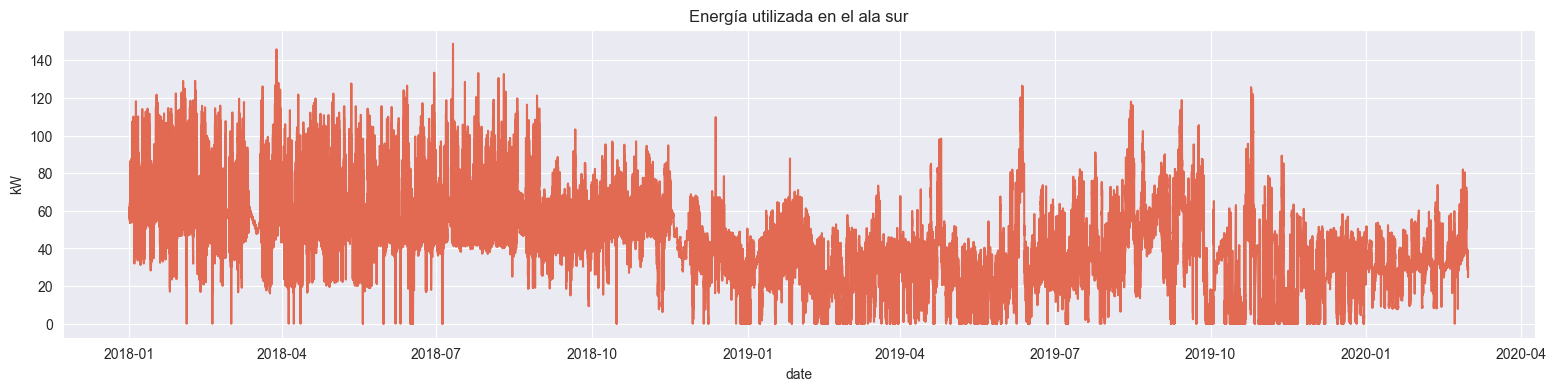

In [11]:
plt.figure(figsize=(19,4))
sns.lineplot(x =energy_use.index , y=energy_use[var])
plt.ylabel('kW')

plt.title('Energía utilizada en el ala sur')

In [12]:
# We crop until March 2020, since it's the expected normal use (covid effect)

energy_use=energy_use[energy_use.index < '2020-03-01 00:00:00']


In [13]:
energy_use = energy_use.resample('15T').mean()


In [14]:
#Split into train and test:

df_train = energy_use.iloc[:-2000,:][var]
df_test = energy_use.iloc[-2000:, :][var]

## TBATS with box cox


The variable we will study is 'hvac_N' (air conditioning in north wing).

In [15]:
from scipy.stats import boxcox

box_cox_df,lam = boxcox(energy_use[var])
print('Lambda: %f' % lam)


Lambda: 0.687402


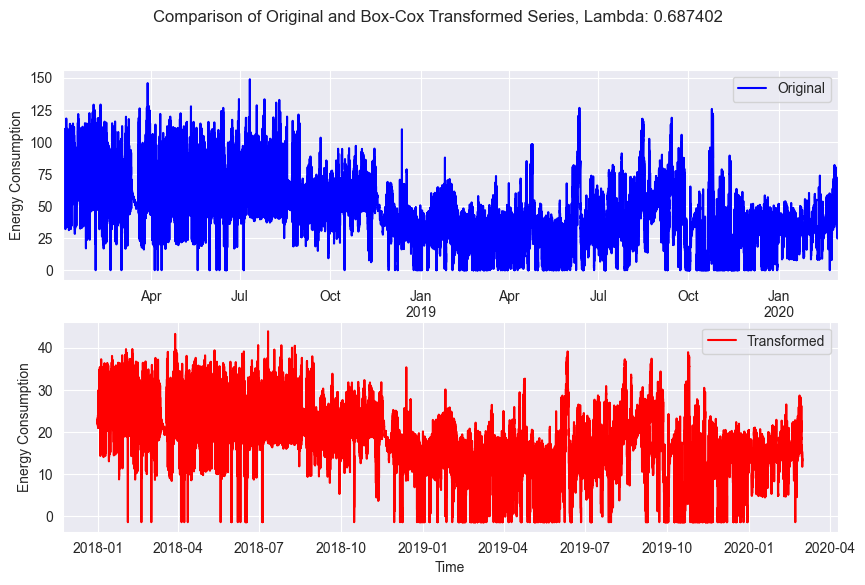

In [16]:
fig, ax = plt.subplots(2,1,figsize=(10,6))

# plot the original series
energy_use[var].plot(ax=ax[0], color='blue', label='Original')

# plot the transformed series
sns.lineplot(ax=ax[1],y=box_cox_df, x=energy_use[var].index, color='red', label='Transformed')

# set the axis labels and title
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Energy Consumption')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Energy Consumption')
plt.suptitle('Comparison of Original and Box-Cox Transformed Series, Lambda: %f' % lam)

# add a legend
ax[0].legend()

# show the plot
plt.show()

In [18]:
box_cox_df = pd.DataFrame(box_cox_df, columns=[var], index=energy_use.index)
box_cox_train = box_cox_df.iloc[:-2000,:][var]
box_cox_test = box_cox_df.iloc[-2000:, :][var]

In [19]:
from tbats import TBATS, BATS


# Fit the model
estimator = TBATS(seasonal_periods=(4,96, 96*7),use_box_cox=False, n_jobs=4)
model = estimator.fit(box_cox_train)


In [20]:
y_forecast=model.forecast(steps=2000)

In [21]:

results_tbats_df = pd.DataFrame(df_test)
results_tbats_df['forecast'] = y_forecast

In [22]:
df_test.shape

(2000,)

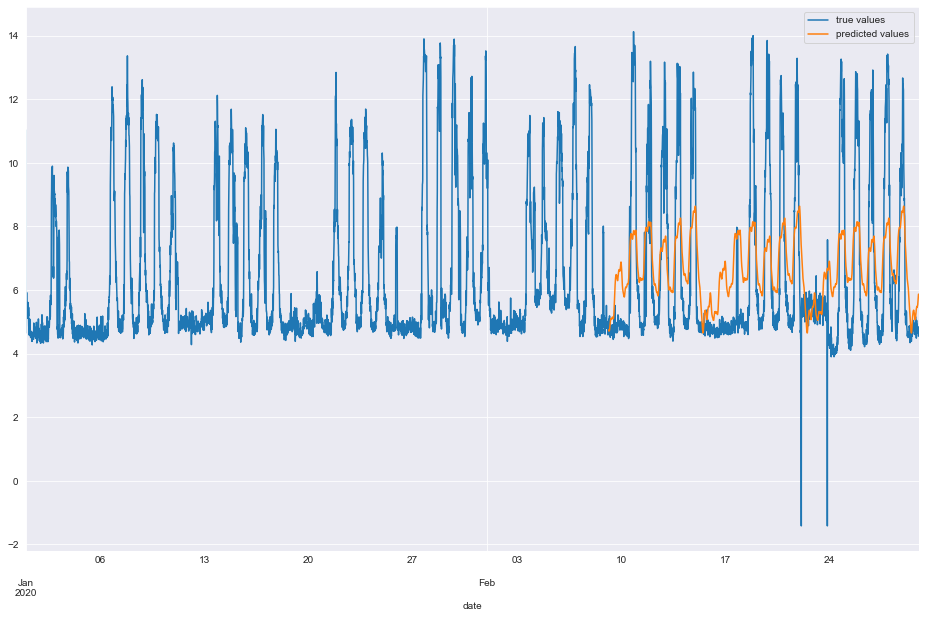

In [23]:
plt.figure(figsize=(16, 10))
df = box_cox_df
#Out of sample forecast
ax = df[df.index.year == 2020][var].plot(label='true values')
results_tbats_df['forecast'].plot(label='predicted values', ax=ax)
plt.legend()

In [24]:
metrics2(y_forecast, df_test)

TRAIN SET METRICS
mae: 6.137455535993313
mape: 1.0956907453133709
rmse: 8.654205959532465


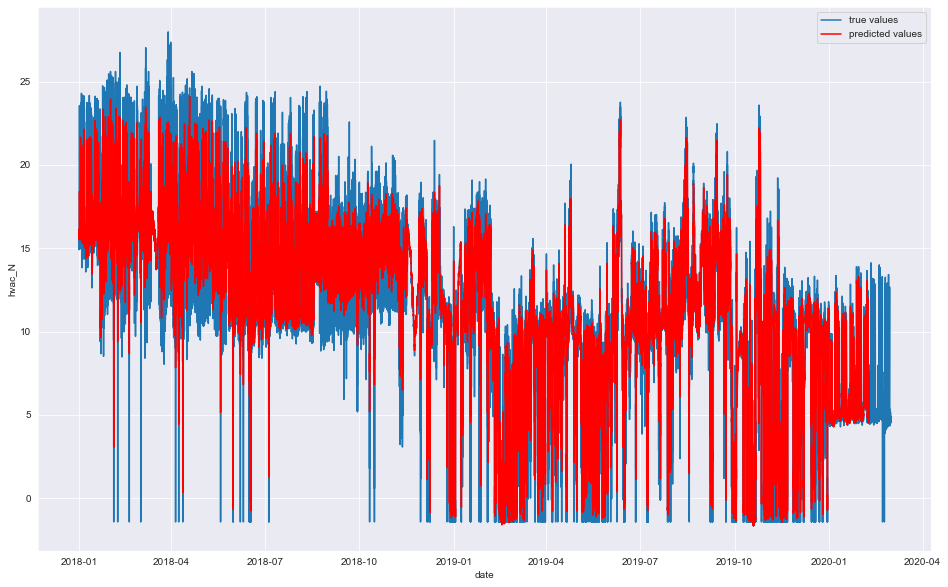

In [25]:
#We check in sample forecasts
plt.figure(figsize=(16, 10))
#Out of sample forecast
sns.lineplot(x=box_cox_df.index, y=box_cox_df[var], label='true values')
sns.lineplot(y=model.y_hat, x=df_train.index, label='predicted values', color='red')
plt.legend()


In [26]:
metrics2(model.y_hat, df_train, text='TRAIN')

TRAIN SET METRICS
mae: 15.380156199455564
mape: 8.215494469394143
rmse: 18.10840456399139


In [ ]:

# Reading model parameters
print(model.params.alpha)
print(model.params.beta)
print(model.params.x0)
print(model.params.components.use_box_cox)
print(model.params.components.seasonal_harmonics)

0.28988295675415304
-0.007898932643565339
[38.26049836  0.18379107  0.0602386  -0.03929448  1.0426391  -2.27365502
 -1.22559048 -0.28960039  0.61302393  0.12838775 -0.77080547 -0.59531249
  1.01801311  1.53463794  0.05583761 -0.42549878 -0.1102852   0.61582956
  0.          0.          0.          0.          0.        ]
False
[1 1 6]


In [ ]:
print(model.params.components.summary())

Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal periods: [  4.  96. 672.]
Seasonal harmonics [1 1 6]
ARMA errors (p, q): (2, 3)



# Unobserved Components

We have already used this to decompose the time series, but this time we will be making forecasts with it

In [17]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

model_UC1 = sm.tsa.UnobservedComponents(df_train,
                                        level='lldtrend',
                                        irregular=True,
                                        stochastic_level = False,
                                        stochastic_trend = False,
                                        stochastic_freq_seasonal = [False, False, False],
                                        freq_seasonal=[{'period': 4, 'harmonics': 2},
                                                       {'period': 96, 'harmonics': 3},
                                                       {'period': 96*7, 'harmonics': 5}])
#fitting model to train data
model_UC1res = model_UC1.fit()

#printing statsmodels summary for model
print(model_UC1res.summary())

print("")

/Users/maguado/miniconda/lib/python3.10/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.17737D+00    |proj g|=  3.18212D-02

At iterate    5    f=  3.59658D+00    |proj g|=  2.02147D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     21      1     0     0   3.910D-06   3.588D+00
  F =   3.5882393929253862     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                               Unobserved Components Results                                
Dep. Variable:                         

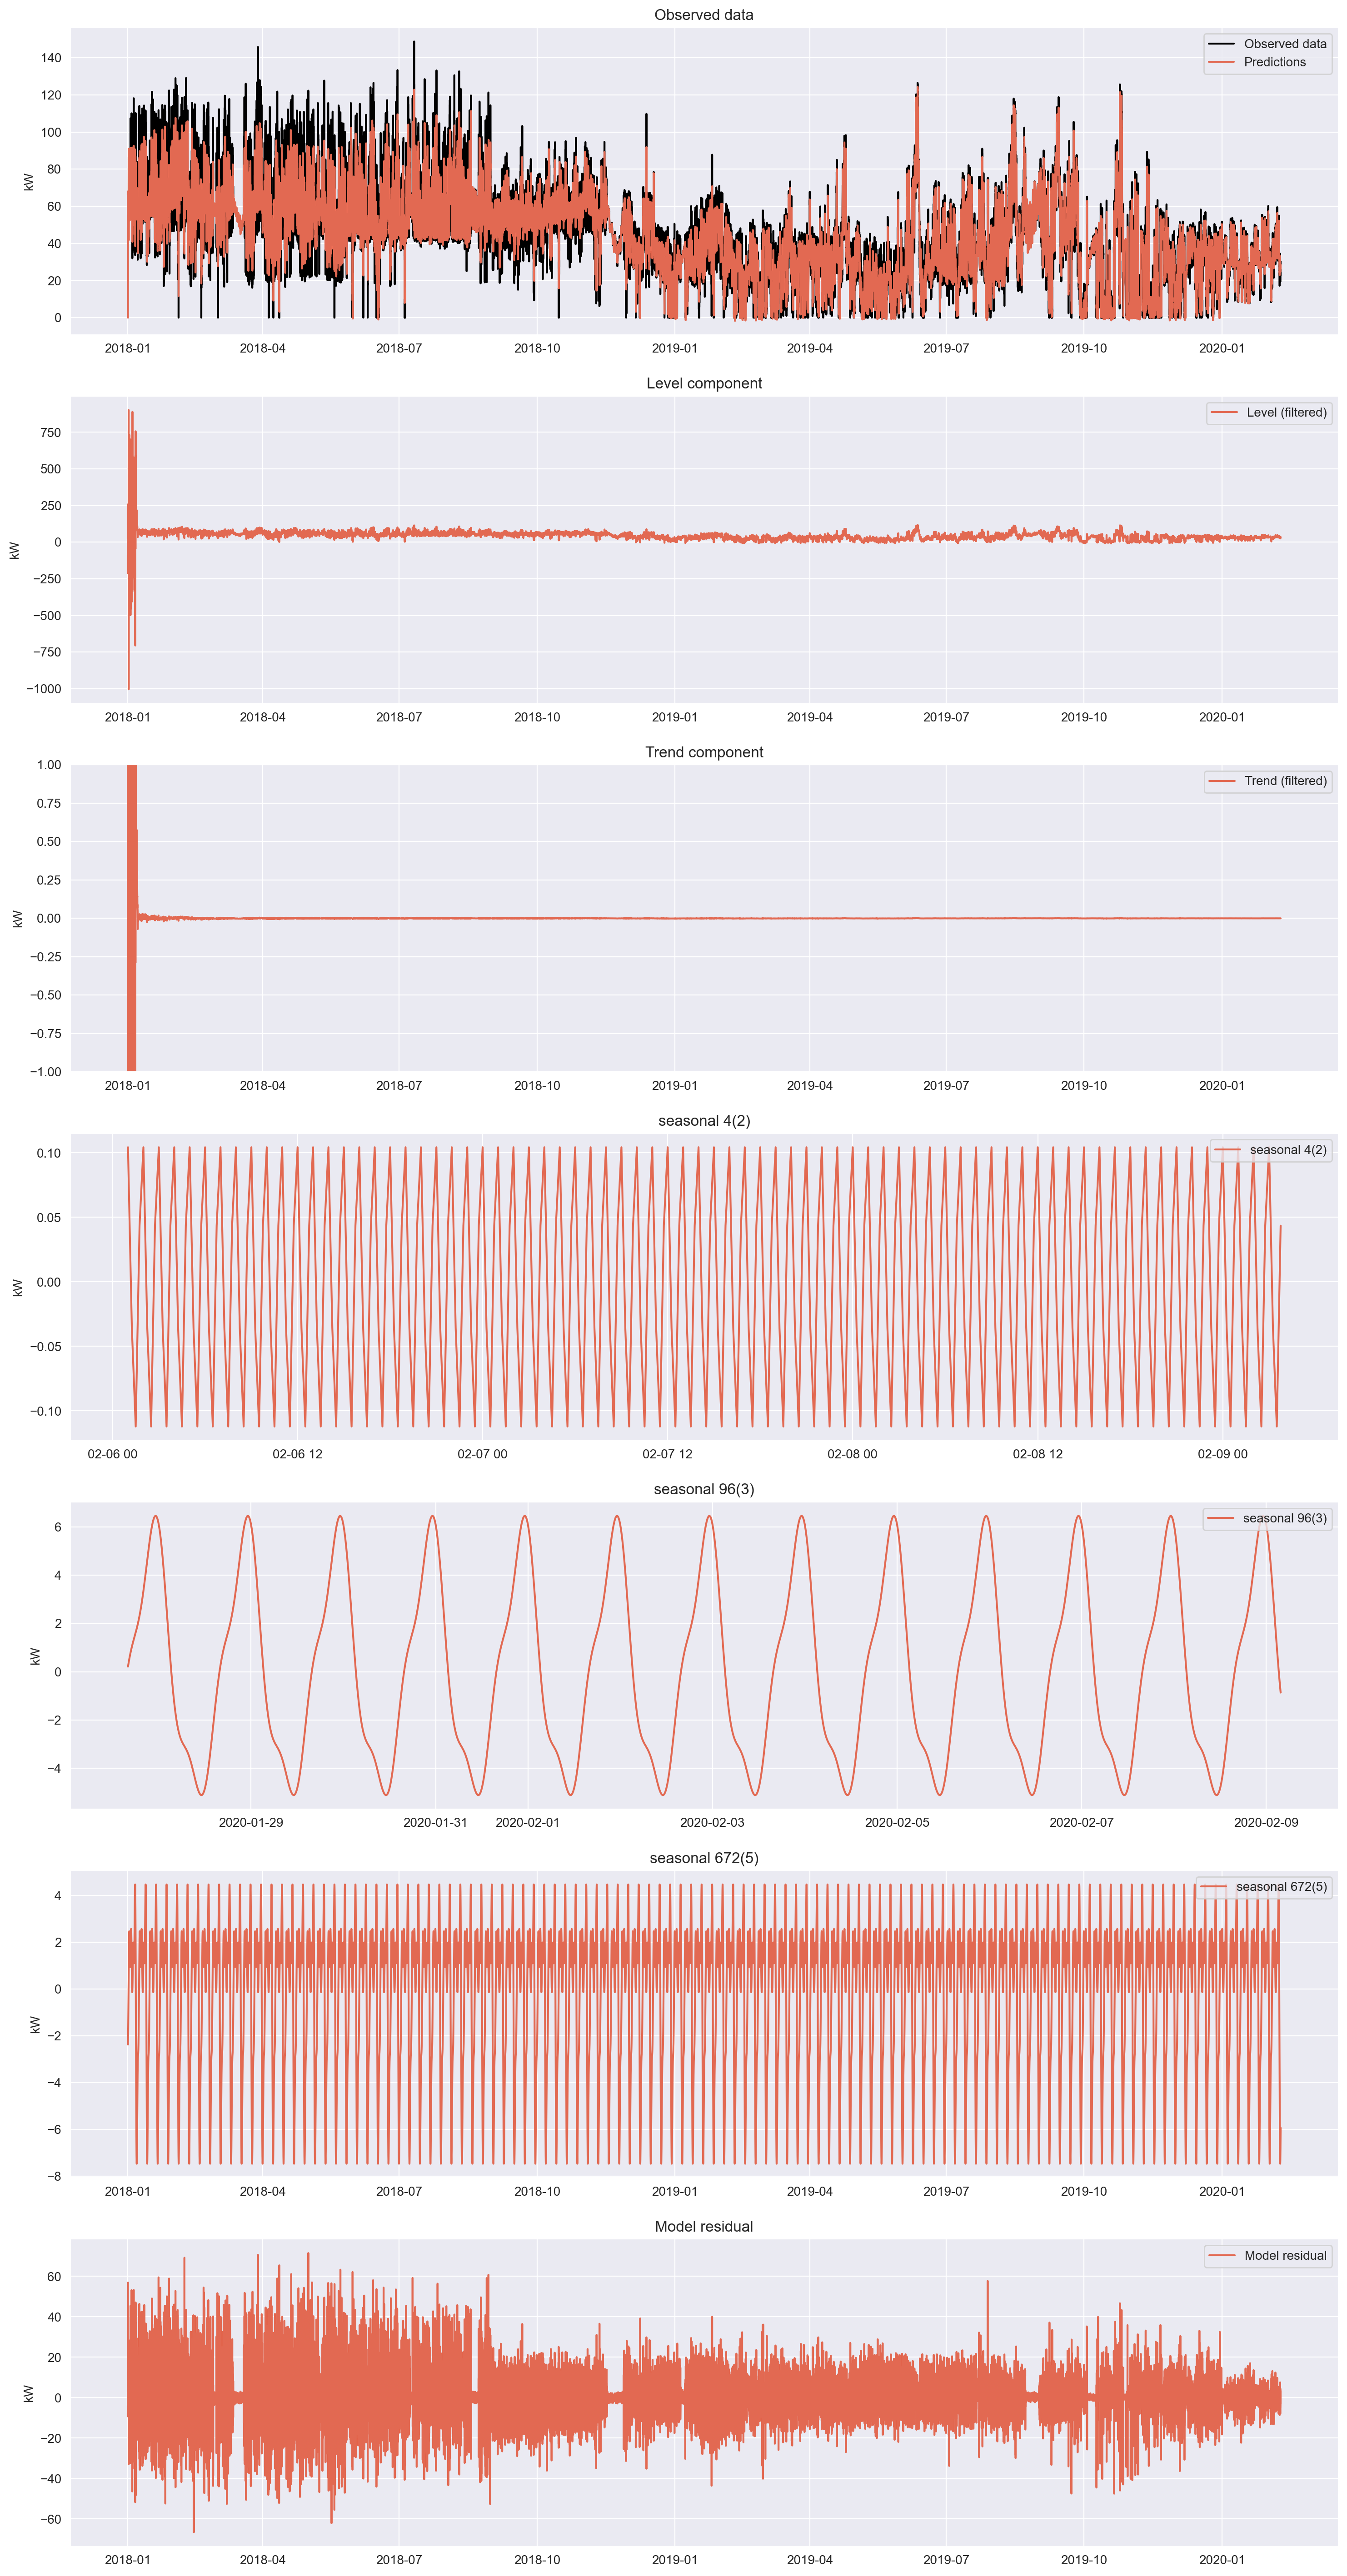

In [18]:
f, axes = plt.subplots(7,1,figsize=(18,36),dpi=200)

#custom plotting of observed train data in style of results class '.plot_components()' method

#plotting observed data
axes[0].plot(df_train, label='Observed data', color='black')
axes[0].plot(model_UC1res.fittedvalues, label='Predictions')
axes[0].legend()

#plotting smoothed level component
axes[1].plot(df_train.index, model_UC1res.level['filtered'], label='Level (filtered)')
axes[1].legend()

#plotting smoothed trend component
axes[2].plot(df_train.index, model_UC1res.trend['filtered'], label='Trend (filtered)')
axes[2].set_ylim(-1,1)
axes[2].legend()

limits = [-300, -1200, 0]

#plotting smoothed seasonal components with arbitrary time window scales
for i in range(3,6,1):
    axes[i].plot(df_train.index[limits[i-3]:], model_UC1res.freq_seasonal[i-3]['smoothed'][limits[i-3]:], label=model_UC1res.freq_seasonal[i-3]['pretty_name'])
    axes[i].legend(loc='upper right')

#plotting residuals
axes[6].plot(df_train.index, model_UC1res.resid, label='Model residual')
axes[6].legend()

#list of subplot titles
axtitles = ['Observed data',
            'Level component',
            'Trend component',
            model_UC1res.freq_seasonal[0]['pretty_name'],
            model_UC1res.freq_seasonal[1]['pretty_name'],
            model_UC1res.freq_seasonal[2]['pretty_name'],
            'Model residual']

#setting y labels and subplot titles (former is missing from '.plot_components()')
for i,a in enumerate(axes):
    a.set_ylabel('kW')
    a.set_title(axtitles[i])

plt.show()

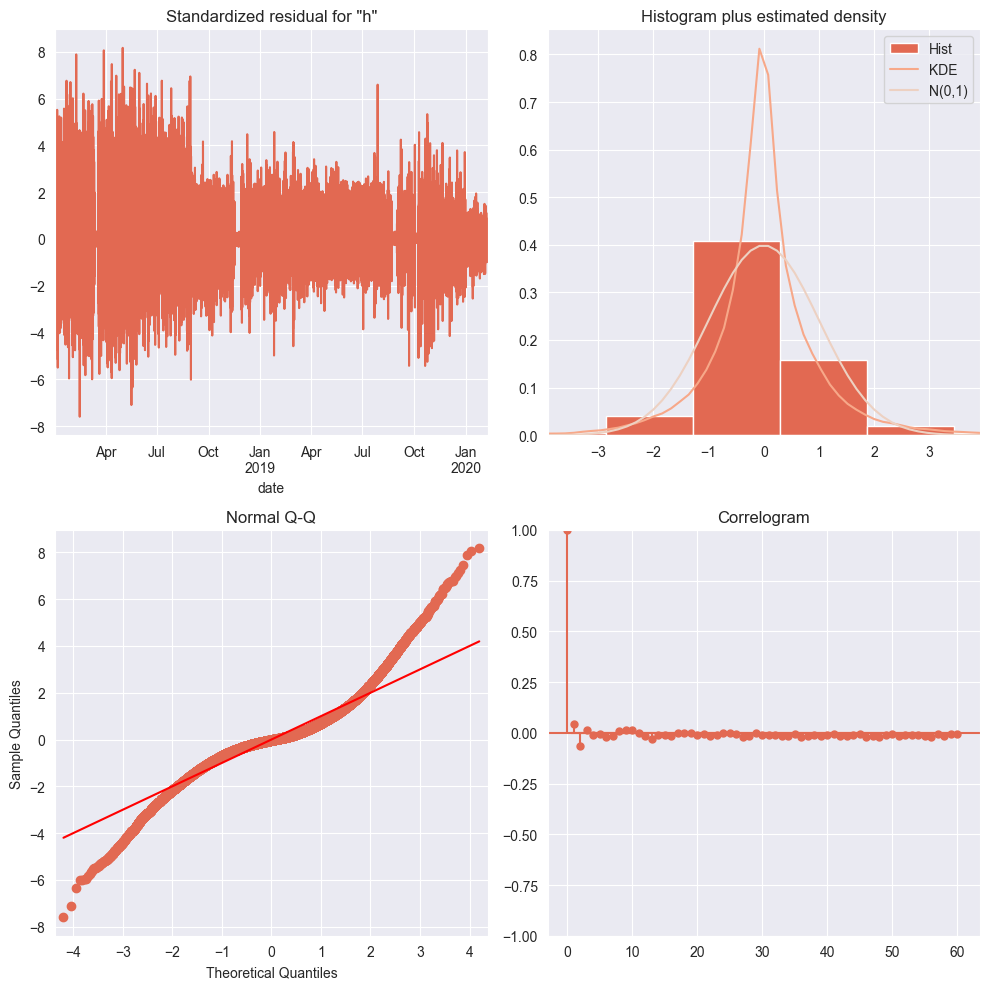

In [19]:
model_UC1res.plot_diagnostics(figsize=(10,10),lags=60)
plt.tight_layout()
plt.show()

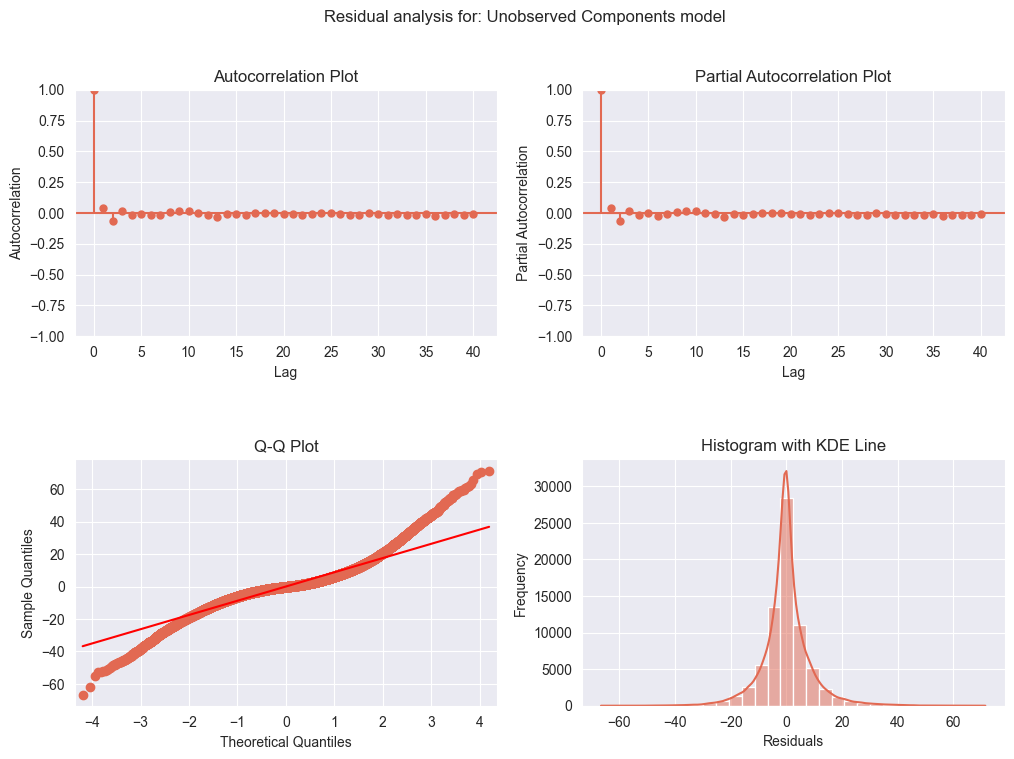

The residuals do not follow a normal distribution (p-value = 0.00000000000000000000, alpha = 0.05)
The residuals are autocorrelated (some p-values < alpha = 0.0500000000)
           lb_stat     lb_pvalue
1       125.886309  3.256134e-29
2       419.931263  6.502566e-92
3       431.898775  2.722738e-93
4       445.144008  4.871068e-95
5       448.178622  1.213802e-94
...            ...           ...
6256  22071.115722  0.000000e+00
6257  22071.531604  0.000000e+00
6258  22072.957098  0.000000e+00
6259  22073.751397  0.000000e+00
6260  22085.571316  0.000000e+00

[6260 rows x 2 columns]
Durbin Watson:  1.9168498469287112
No autocorrelation


In [20]:
residual_analysis(model_UC1res.resid, title="Unobserved Components model")

In [21]:
#Forecasting
forecast_UC1 = model_UC1res.forecast(steps=2000)

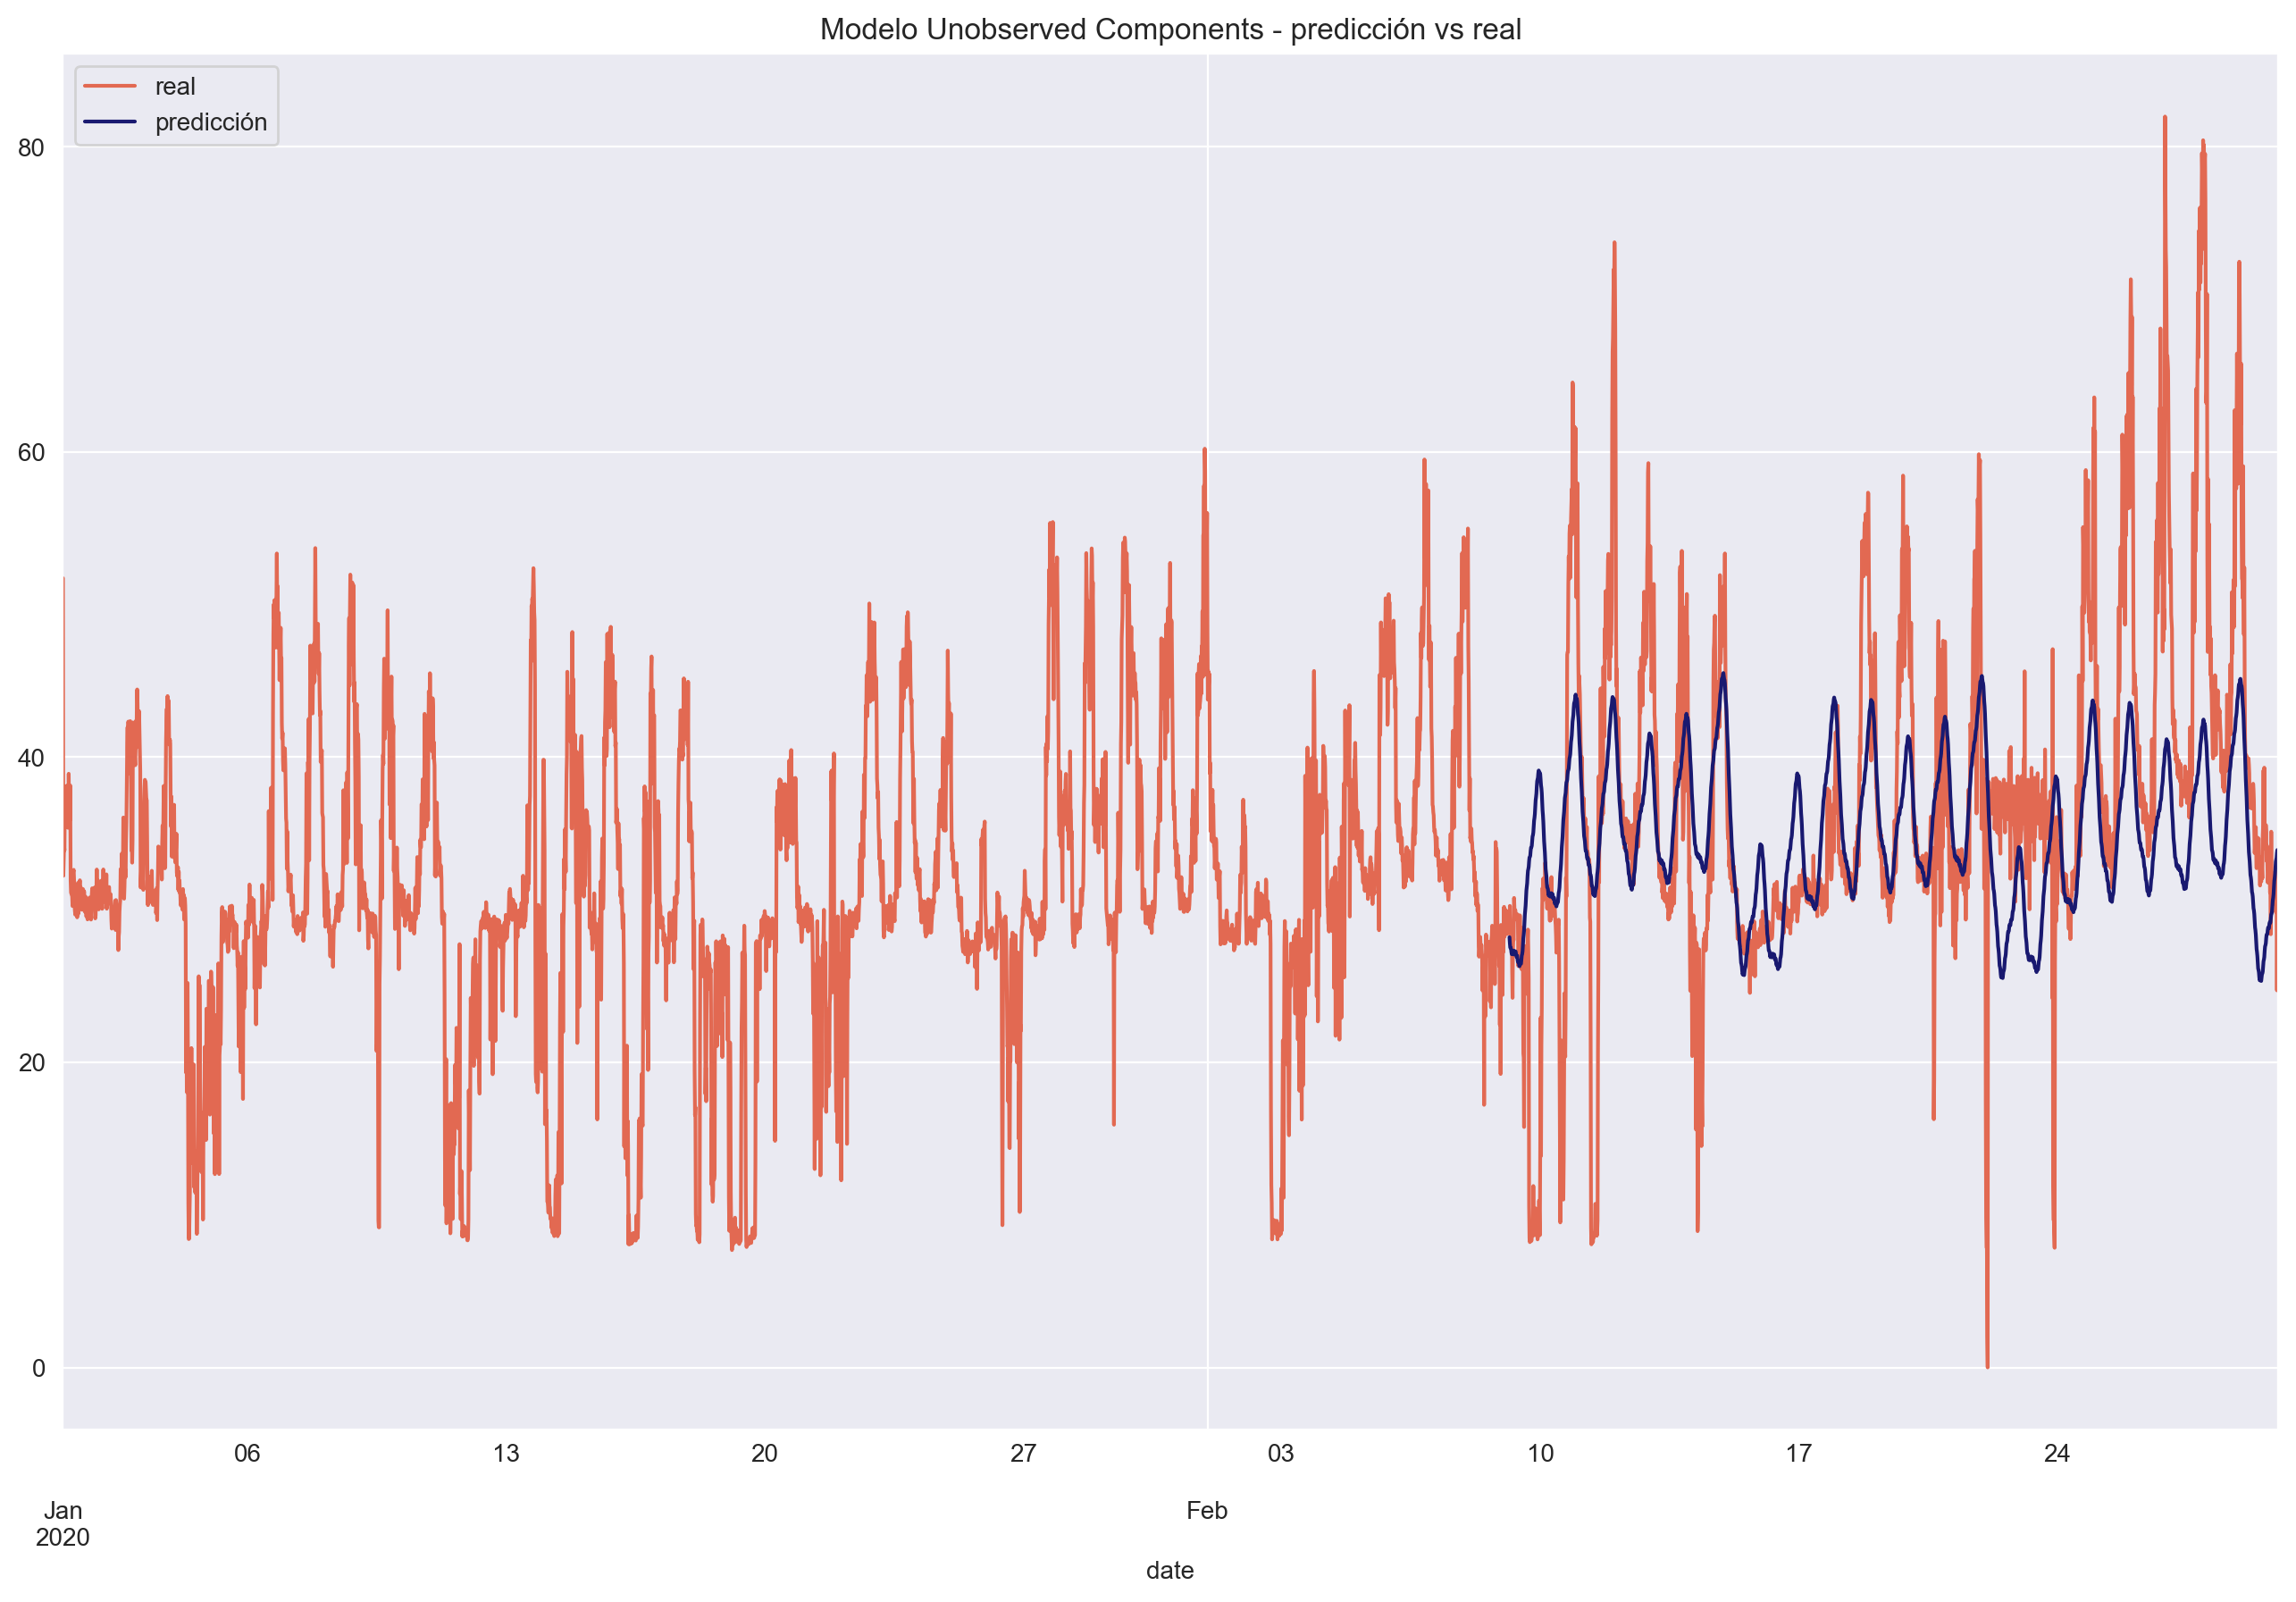

In [24]:

results_UC1 = pd.DataFrame(df_test)
results_UC1['forecast'] = forecast_UC1

plt.figure(figsize=(16, 10), dpi=200)
df = energy_use
#Out of sample forecast
ax = df[df.index.year == 2020][var].plot(label='real')
results_UC1['forecast'].plot(label='predicción', ax=ax, color='midnightblue')
plt.title("Modelo Unobserved Components - predicción vs real")
plt.legend()

In [25]:
metrics2(forecast_UC1, df_test, "TEST")

TEST SET METRICS
mae: 6.7909823658447985
mape: 2.1492341626499125
rmse: 9.890584845037147


In [26]:
metrics2(model_UC1res.fittedvalues, df_train, "TRAIN")

TRAIN SET METRICS
mae: 5.730344782178654
mape: 13.164094242160914
rmse: 8.772918264323016


We are going to perform a grid search to look for the best parameter combination. We will test it with cross validation using time series split:

In [42]:
from sklearn.model_selection import TimeSeriesSplit


# number of splits for time series split cross-validation
n_splits = 5

# Initialize a list to store the evaluation metrics for each fold
fold_metrics = []

# Initialize the time series split cross-validator
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=96*7)

# Loop over the folds
for train_index, test_index in tscv.split(energy_use[var]):
    # Split the data into training and testing sets
    train_data = energy_use.iloc[train_index][var]
    test_data = energy_use.iloc[test_index][var]
    
    # Fit the UnobservedComponents model to the training data
    model_UC = sm.tsa.UnobservedComponents(train_data,
                                        level='lldtrend',
                                        irregular=True,
                                        stochastic_level = False,
                                        stochastic_trend = False,
                                        stochastic_freq_seasonal = [False, False, False],
                                        freq_seasonal=[{'period': 4, 'harmonics': 2},
                                                       {'period': 96, 'harmonics': 3},
                                                       {'period': 96*7, 'harmonics': 5}])

    fitted_model = model_UC.fit(verbose=0)
    
    # Forecast the next period using the fitted model
    forecast = fitted_model.forecast(steps=len(test_data))
    
    # Evaluate the forecast using a suitable metric (e.g. RMSE)
    mae = mean_absolute_error(test_data, forecast)
    mape = mean_absolute_percentage_error(test_data, forecast)
    rmse = np.sqrt(mean_squared_error(test_data, forecast))

    fold_metrics.append([test_index[0],mae,mape,rmse])
    



/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71822D+00    |proj g|=  4.87943D-02

At iterate    5    f=  3.17367D+00    |proj g|=  5.42447D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     20      1     0     0   5.123D-07   3.174D+00
  F =   3.1736645314038654     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71772D+00    |proj g|=  4.89078D-02

At iterate    5    f=  3.22966D+00    |proj g|=  4.52103D-02

At iterate   10    f=  3.16989D+00    |proj g|=  4.56060D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     23      1     0     0   3.101D-07   3.170D+00
  F =   3.1698853035756236     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16


 This problem is unconstrained.


 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71696D+00    |proj g|=  4.90310D-02

At iterate    5    f=  3.21451D+00    |proj g|=  4.89702D-02

At iterate   10    f=  3.16579D+00    |proj g|=  4.27084D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     20      1     0     0   6.528D-08   3.166D+00
  F =   3.1657909327627407     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71640D+00    |proj g|=  4.91433D-02


 This problem is unconstrained.



At iterate    5    f=  3.22086D+00    |proj g|=  4.36287D-02

At iterate   10    f=  3.16204D+00    |proj g|=  4.74625D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     22      1     0     0   4.746D-06   3.162D+00
  F =   3.1620411880966763     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71602D+00    |proj g|=  4.92527D-02


 This problem is unconstrained.



At iterate    5    f=  3.15821D+00    |proj g|=  2.22230D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     16      1     0     0   1.928D-07   3.158D+00
  F =   3.1581757542948319     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [43]:
fold_metrics_df = pd.DataFrame(fold_metrics, columns=['index_test', 'mae', 'mape', 'rmse'])
fold_metrics_df

,index_test,mae,mape,rmse
0,72476,4.150349,0.288537,5.643927
1,73148,3.354862,0.205441,5.196521
2,73820,3.712206,0.210525,6.019140
3,74492,3.668081,1.809243,5.947672
4,75164,3.777299,1.939763,5.488318


## Grid search - hyperparemeter tuning

First, we will iterate through some harmonic values for each of the seasonal components, using cross validation with 2 splits (this kind of fitting is very time expensive)

In [49]:
metrics = {}

for i in range(2,8):
    mape_t=[]
   
    tscv = TimeSeriesSplit(n_splits=2, test_size=96*7)

    for train_index, test_index in tscv.split(energy_use[var]):
        # Split the data into training and testing sets
        train_data = energy_use.iloc[train_index][var]
        test_data = energy_use.iloc[test_index][var]
        
        # Fit the UnobservedComponents model to the training data
        model_UC = sm.tsa.UnobservedComponents(train_data,
                                            level='lldtrend',
                                            irregular=True,
                                            stochastic_level = False,
                                            stochastic_trend = False,
                                            stochastic_freq_seasonal = [False, False, False],
                                            freq_seasonal=[{'period': 4, 'harmonics': 2},
                                                        {'period': 96, 'harmonics': 3},
                                                        {'period': 96*7, 'harmonics': i}])

        fitted_model = model_UC.fit(verbose=0)
        
        # Forecast the next period using the fitted model
        forecast = fitted_model.forecast(steps=len(test_data))
        
        # Evaluate the forecast using a suitable metric (e.g. RMSE)
        mape_t.append( mean_absolute_percentage_error(test_data, forecast))
        
    rmse = np.sqrt(mean_squared_error(df_test, test_forecast))
    mape = np.mean(mape_t)
    metrics[i]=mape

    

        

/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71623D+00    |proj g|=  4.91532D-02


 This problem is unconstrained.



At iterate    5    f=  3.22094D+00    |proj g|=  4.37557D-02

At iterate   10    f=  3.16183D+00    |proj g|=  9.46301D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     22      1     0     0   9.463D-06   3.162D+00
  F =   3.1618320166866596     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71585D+00    |proj g|=  4.92626D-02

At iterate    5    f=  3.15804D+00    |proj g|=  2.77872D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     15      1     0     0   6.526D-06   3.158D+00
  F =   3.1579678994427365     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71628D+00    |proj g|=  4.91498D-02

At iterate    5    f=  3.22090D+00    |proj g|=  4.37040D-02

At iterate   10    f=  3.16193D+00    |proj g|=  1.01813D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     23      1     0     0   2.389D-08   3.162D+00
  F =   3.1619293569606639     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71590D+00    |proj g|=  4.92592D-02

At iterate    5    f=  3.15817D+00    |proj g|=  3.40973D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     16      1     0     0   6.241D-06   3.158D+00
  F =   3.1580642718026053     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71634D+00    |proj g|=  4.91465D-02


 This problem is unconstrained.



At iterate    5    f=  3.22088D+00    |proj g|=  4.36518D-02

At iterate   10    f=  3.16204D+00    |proj g|=  4.69491D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     22      1     0     0   4.695D-06   3.162D+00
  F =   3.1620368017367069     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71596D+00    |proj g|=  4.92559D-02

At iterate    5    f=  3.15827D+00    |proj g|=  3.40317D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     16      1     0     0   7.737D-06   3.158D+00
  F =   3.1581700684343157     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71640D+00    |proj g|=  4.91433D-02


 This problem is unconstrained.



At iterate    5    f=  3.22086D+00    |proj g|=  4.36287D-02

At iterate   10    f=  3.16204D+00    |proj g|=  4.74625D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     22      1     0     0   4.746D-06   3.162D+00
  F =   3.1620411880966763     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71602D+00    |proj g|=  4.92527D-02

At iterate    5    f=  3.15821D+00    |proj g|=  2.22230D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     16      1     0     0   1.928D-07   3.158D+00
  F =   3.1581757542948319     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71647D+00    |proj g|=  4.91404D-02

At iterate    5    f=  3.22086D+00    |proj g|=  4.36326D-02

At iterate   10    f=  3.16195D+00    |proj g|=  4.62665D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     22      1     0     0   4.627D-06   3.162D+00
  F =   3.1619540063114155     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71609D+00    |proj g|=  4.92499D-02

At iterate    5    f=  3.15809D+00    |proj g|=  1.36774D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     15      1     0     0   7.533D-07   3.158D+00
  F =   3.1580780244025988     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71637D+00    |proj g|=  4.91390D-02

At iterate    5    f=  3.22070D+00    |proj g|=  4.36031D-02

At iterate   10    f=  3.16187D+00    |proj g|=  2.69798D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     25      1     0     0   4.967D-05   3.162D+00
  F =   3.1618732677533128     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: verbose. After release 0.14, this will raise.
  warnings.warn(


RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71599D+00    |proj g|=  4.92485D-02

At iterate    5    f=  3.15850D+00    |proj g|=  6.88174D-03

At iterate   10    f=  3.15800D+00    |proj g|=  3.28273D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     26      1     0     0   3.545D-05   3.158D+00
  F =   3.1579981106813255     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [50]:
metrics

{2: 1.5835679247031256,
 3: 1.729762695558441,
 4: 1.8377467537546495,
 5: 1.874502838928633,
 6: 1.9026060995913299,
 7: 1.9026107985423395}

In [27]:
def cross_validation_UC(df, params,n_splits=3 ):
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=96*7)
    mape_t=[]
    mae_t =[]
    rmse_t=[]
    index =[]
    for train_index, test_index in tscv.split(df):
        # Split the data into training and testing sets
        train_data = energy_use.iloc[train_index][var]
        test_data = energy_use.iloc[test_index][var]
        
        # Fit the UnobservedComponents model to the training data
        model_UC = sm.tsa.UnobservedComponents(train_data,**params)

        fitted_model = model_UC.fit(disp=False)
        
        # Forecast the next period using the fitted model
        forecast = fitted_model.forecast(steps=len(test_data))
        
        # Evaluate the forecast using a suitable metric (e.g. RMSE)
        mape_t.append( mean_absolute_percentage_error(test_data, forecast))
        mae_t.append(mean_absolute_error(test_data, forecast))
        rmse_t.append(np.sqrt(mean_squared_error(test_data, forecast)))
        index.append(test_index[0])
    df_results = pd.DataFrame({'index':index, 'mape':mape_t, 'mae':mae_t, 'rmse_t':rmse_t})
    return df_results

Now, we will create a gridsearch to iterate through the parameters

In [71]:
from statsmodels.tsa.statespace.structural import UnobservedComponents
iterables = [ [True, False], [True, False], [True, False]]
# Define the parameter grid
param_grid = {
    'level': [False, 'llevel', 'dtrend', 'lldtrend', 'lltrend', 'strend'],
    'trend': [False, True],
    'seasonal': [None, 12],
    'freq_seasonal': [[{'period': 4, 'harmonics': 2},
                                                        {'period': 96, 'harmonics': 3},
                                                        {'period': 96*7, 'harmonics': 2}]],
    'cycle': [False, True],
    'autoregressive': [None, 1, 2],
    'exog': [None],
    'irregular': [False, True],
    'stochastic_level': [False, True],
    'stochastic_trend': [False, True],
    'stochastic_seasonal': [False, True],
    'stochastic_freq_seasonal': [[i for i in m] for m in itertools.product(*iterables)],
    'stochastic_cycle': [False, True],
    'damped_cycle': [False, True],
    'cycle_period_bounds': [(1.5, 12), (2, 12)],
    'mle_regression': [True, False],
    'use_exact_diffuse': [False, True]
}


all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# Create a list to store MAPE values for each combination
mapes = [] 
maes=[]
# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    df_p = cross_validation_UC(df_train,params, n_splits=2)
    print('Finished combination: ', params)
    print('\tMAPE: ', np.mean(df_p['mape']))
    # Save model performance metrics
    mapes.append(np.mean(df_p['mape']))
    maes.append(np.mean(df_p['mae']))
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
tuning_results['mae']=maes
# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

Finished combination:  {'level': False, 'trend': False, 'seasonal': None, 'freq_seasonal': [{'period': 4, 'harmonics': 2}, {'period': 96, 'harmonics': 3}, {'period': 672, 'harmonics': 2}], 'cycle': False, 'autoregressive': None, 'exog': None, 'irregular': False, 'stochastic_level': False, 'stochastic_trend': False, 'stochastic_seasonal': False, 'stochastic_freq_seasonal': [True, True, True], 'stochastic_cycle': False, 'damped_cycle': False, 'cycle_period_bounds': (1.5, 12), 'mle_regression': True, 'use_exact_diffuse': False}
	MAPE:  1.0893351672935525
Finished combination:  {'level': False, 'trend': False, 'seasonal': None, 'freq_seasonal': [{'period': 4, 'harmonics': 2}, {'period': 96, 'harmonics': 3}, {'period': 672, 'harmonics': 2}], 'cycle': False, 'autoregressive': None, 'exog': None, 'irregular': False, 'stochastic_level': False, 'stochastic_trend': False, 'stochastic_seasonal': False, 'stochastic_freq_seasonal': [True, True, True], 'stochastic_cycle': False, 'damped_cycle': Fals

In [67]:
import warnings
warnings.filterwarnings("ignore")